[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/sklearn/classic-code.ipynb)

# Approaching the problem without machine learning

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
print(pd.__version__)

0.22.0


In [4]:
import numpy as np
print(np.__version__)

1.14.6


In [5]:
import seaborn as sns
print(sns.__version__)

0.7.1


## Loading and exploring our data set
This is a database of customers of an insurance company. Each data point is one customer. The group represents the number of accidents the customer has been involved in in the past

* 0 - red: many accidents
* 1 - green: few or no accidents
* 2 - yellow: in the middle        

In [6]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26783  100 26783    0     0   163k      0 --:--:-- --:--:-- --:--:--  164k


In [0]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')

In [8]:
df.head()

,speed,age,miles,group
0,98.0,44.0,25.0,1
1,118.0,54.0,24.0,1
2,111.0,26.0,34.0,0
3,97.0,25.0,10.0,2
4,114.0,38.0,22.0,1


In [9]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000,0.998667
std,17.604333,17.130400,15.250815,0.816768
min,68.000000,16.000000,1.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,100.000000,84.000000,2.000000


## A pairplot of a few samples gives you a nice overview of your data

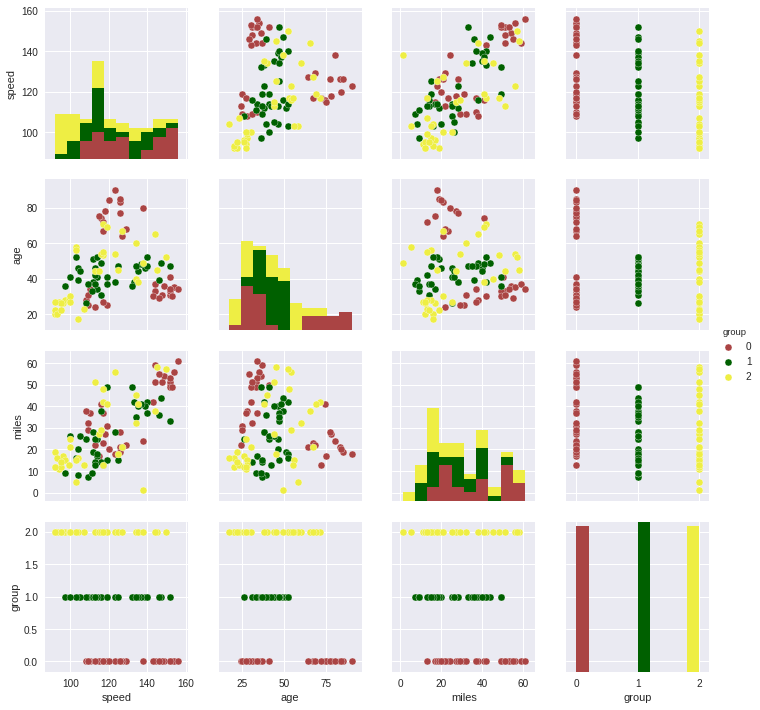

In [10]:
sample_df = df.sample(n=100, random_state=42)
sns.pairplot(sample_df, hue="group", palette={0: '#AA4444', 1: '#006000', 2: '#EEEE44'})

## Choose an intuitive view on your data - plot speed vs age only

In [0]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap

cmap_print = ListedColormap(['#AA8888', '#004000', '#FFFFDD'])
cmap_bold = ListedColormap(['#AA4444', '#006000', '#EEEE44'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25
title_font_size=40

def meshGrid(x_data, y_data):
    h = 1  # step size in the mesh
    x_min, x_max = x_data.min() - 1, x_data.max() + 1
    y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plot_prediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   mesh=True, fname=None, print=False):
    xx,yy = meshGrid(x_data, y_data)
    fig, ax = plt.subplots(figsize=(15, 8))

    if clf and mesh:
        Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    if print:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_print, s=200, marker='o', edgecolors='k')
    else:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_bold, s=100, marker='o', edgecolors='k', alpha=0.7)
        
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    if fname:
        fig.savefig('figures/'+fname)

In [0]:
sample_df = df.sample(n=1000, random_state=42)
y = sample_df['group']
sample_df.drop('group', axis='columns', inplace=True)
X = sample_df.as_matrix()

In [49]:
X[:10]

array([[104.,  39.,   8.],
       [123.,  38.,  28.],
       [145.,  45.,  58.],
       [134.,  60.,  32.],
       [140.,  52.,  42.],
       [117.,  53.,  48.],
       [ 96.,  26.,  17.],
       [ 92.,  20.,  12.],
       [104.,  46.,  20.],
       [ 92.,  22.,  19.]])

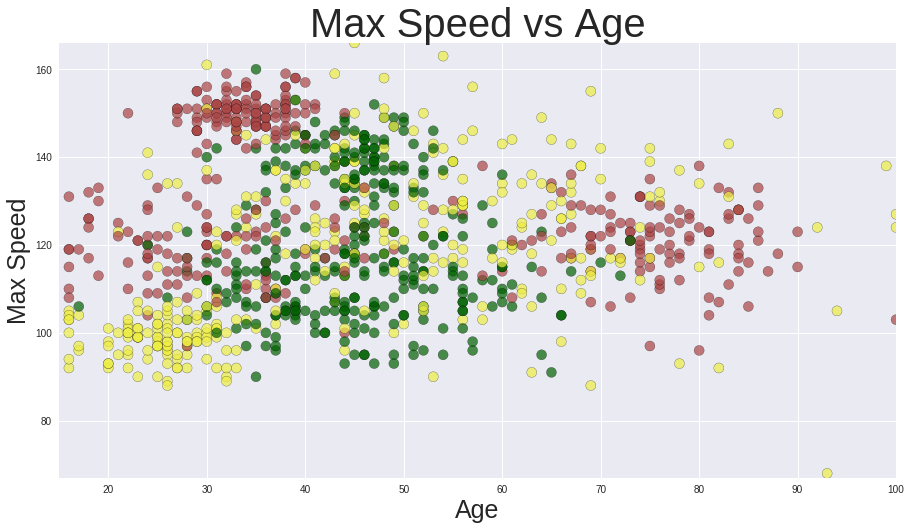

In [50]:
plot_prediction(None, X[:, 1], X[:, 0], 
               'Age', 'Max Speed', y, mesh=False,
                title="Max Speed vs Age")

# Our objective: Create a general model to predict  the risk group from our features

In [0]:
# 0: red
# 1: green
# 2: yellow

class ClassifierBase:
    def predict(self, X):
        return np.array([ self.predict_single(x) for x in X])
    def score(self, X, y):
        n = len(y)
        correct = 0
        predictions = self.predict(X)
        for prediction, ground_truth in zip(predictions, y):
            if prediction == ground_truth:
                correct = correct + 1
        return correct / n

### First a random model as a base line - how well do you think will it perform?

In [0]:
from random import randrange

class RandomClassifier(ClassifierBase):
    def predict_single(self, x):
        return randrange(3)

In [0]:
random_clf = RandomClassifier()

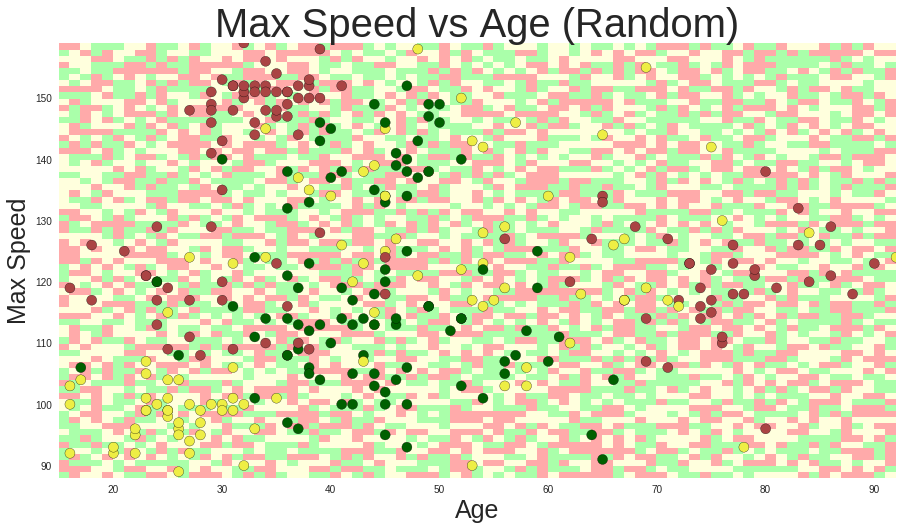

In [18]:
plot_prediction(random_clf, X[:, 1], X[:, 0], 
               'Age', 'Max Speed', y,
                title="Max Speed vs Age (Random)")

### By just randomly guessing, we get approx. 1/3 right, which is what we expect

In [19]:
random_clf.score(X, y)

0.37666666666666665

### Creating a naive classifier manually, how much better is it?

In [0]:
# 0: red
# 1: green
# 2: yellow

class BaseLineClassifier(ClassifierBase):
    def predict_single(self, x):
        try:
            speed, age, miles_per_year = x
        except:
            speed, age = x
            miles_per_year = 0
        if age < 25:
            if speed > 140:
                return 0
            else:
                return 2
        if age > 75:
            return 0
        if miles_per_year > 30:
            return 0
        if miles_per_year > 20:
            return 2
        return 1

In [0]:
base_clf = BaseLineClassifier()

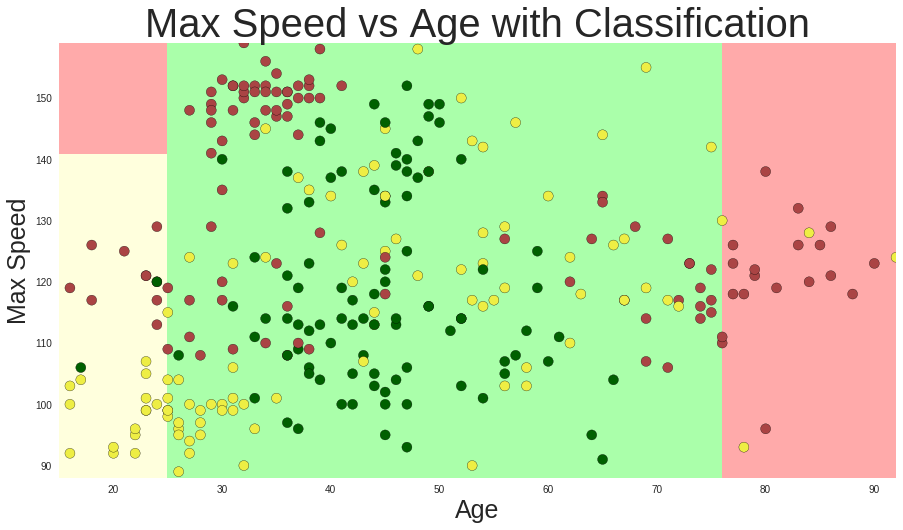

In [22]:
plot_prediction(base_clf, X[:, 1], X[:, 0], 
               'Age', 'Max Speed', y,
                title="Max Speed vs Age with Classification")

### This is the baseline we have to beat

In [23]:
base_clf.score(X, y)

0.43666666666666665